### import libraries

In [1]:
import os
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import xml.etree.ElementTree as ET

### Load and preprocess data

In [19]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images, self.labels = self._load_images()

    def _load_images(self):
        images = []
        labels = []
        class_names = ['adults', 'children']
        
        for label, class_name in enumerate(class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    xml_name = f'{os.path.splitext(img_name)[0]}.xml'
                    if img_name.endswith(('.jpg')):
                        images.append(os.path.join(class_dir, img_name))
                        labels.append(label)
                    # if os.path.exists(xml_name):
                    #     tree = ET.parse(xml_name)
                    #     root = tree.getroot()
                    #     bndbox = root.find('object').find('bndbox')
                    #     bbs.append(bndbox)
        return images, labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        xml_name = f'{os.path.splitext(img_path)[0]}.xml'
        if os.path.exists(xml_name) and 1 == 0:
            tree = ET.parse(xml_name)
            root = tree.getroot()
            bndbox = root.find('object').find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            image = Image.open(img_path).convert("RGB")
            image = image.crop([xmin, ymin, xmax, ymax])
        else:
            image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [20]:
# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.ToTensor()
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_root_dir = './dataset/dataset/train'
trainset = ImageDataset(root_dir = train_root_dir, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True)

test_root_dir = './dataset/dataset/test'
testset = ImageDataset(root_dir = test_root_dir, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

# Define class names
classes = ('adult', 'child', 'three', 'four')

### visualize the data

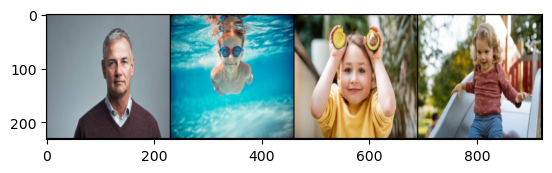

adult child child child


In [21]:
# Function to display images
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### define CNN

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # pic size origin resized to 
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 11, 5)
        self.conv3 = nn.Conv2d(11, 16, 5)
        self.fc1 = nn.Linear(16 * 25 * 25, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 25 * 25)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### define loss function and optimizer

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train the model

In [24]:
num_epochs = 10
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'Epoch{epoch + 1}, Loss: {running_loss/len(trainloader)}')

print('Finished Training')

Epoch1, Loss: 0.6944338662283761
Epoch2, Loss: 0.6943765389067786
Epoch3, Loss: 0.6938510647841862
Epoch4, Loss: 0.6934087991714477
Epoch5, Loss: 0.6935376444033214
Epoch6, Loss: 0.6933980516024998
Epoch7, Loss: 0.6935603099209922
Epoch8, Loss: 0.6935502022504807
Epoch9, Loss: 0.6935064171041762
Epoch10, Loss: 0.6931804312126977
Finished Training


### evaluate the model

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 50.0 %


### view the result

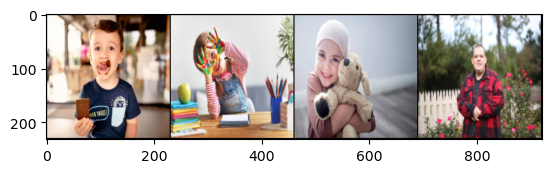

adult child adult child


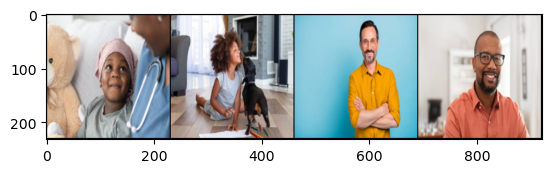

child child adult child


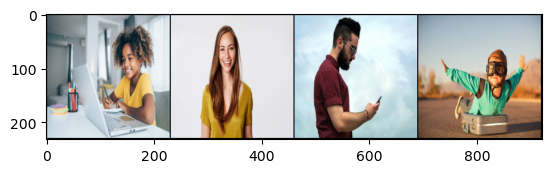

child child adult adult


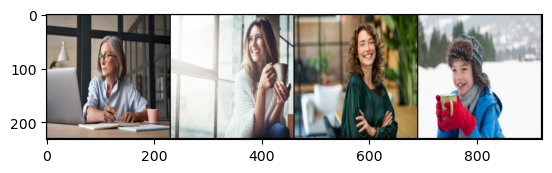

child child child child


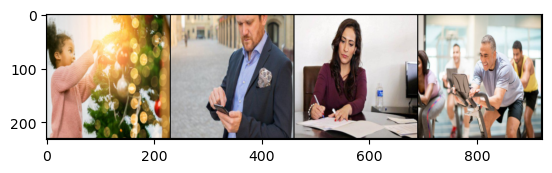

child child adult child
Accuracy of adult : 30.0 %
Accuracy of child : 78.33333333333333 %


In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
a = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        
        _, predicted = torch.max(outputs, 1)
        if a < 5:
            imshow(torchvision.utils.make_grid(images))
            print(' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))
            a+=1
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print(f'Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]} %')